In [56]:
import pandas as pd
import torch
from torch.optim import SGD, NAdam
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset

from argparse import Namespace

from tqdm import tqdm

from collections import deque

import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, balanced_accuracy_score, roc_auc_score

### Credit Risk Assessment Usin ResNet
- Binary classification
- Deep Residual Learning for Image Recognition

## Preprocessing
Data preprocessing based on the data type/category:
- categorical binary data
  - binary label encoding
  - class (target atribút, [0='bad' 1='good']), foreign_worker, own_telephone
- categorical ordinal data
  - label encoding, kde lepšie ordinálne hodnoty boli zakódované ako väčšie numerické hodnoty
  - employment, savings_status, credit_history, checking_status, job
residence_since
- catergorical non-ordinal data
  - one-hot encoding
  - housing, other_payment_plans, property_magnitude, other_parties, personal_status, purpose
- scaled with MinMaxScaler to values -> <0;1>



In [17]:
df = pd.read_csv('processed_data.csv', index_col=0)
df.head()

,checking_status,duration,credit_history,credit_amount,savings_status,employment,installment_commitment,residence_since,age,existing_credits,...,purpose_'domestic appliance',purpose_'new car',purpose_'used car',purpose_business,purpose_education,purpose_furniture/equipment,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining
0,0.333333,0.029412,0.00,0.050567,0.00,1.00,1.000000,1.000000,0.857143,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.666667,0.647059,0.50,0.313690,0.25,0.50,0.333333,0.333333,0.053571,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000000,0.117647,0.00,0.101574,0.25,0.75,0.333333,0.666667,0.535714,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,0.558824,0.50,0.419941,0.25,0.75,0.333333,1.000000,0.464286,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.333333,0.294118,0.25,0.254209,0.25,0.50,0.666667,1.000000,0.607143,0.333333,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Splitting the data on train, valid and test datasets

In [59]:
X = df.drop('class', axis=1)
y = df['class']

X_train_and_valid, X_test, y_train_and_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_and_valid, y_train_and_valid, test_size=0.25, random_state=1, stratify=y_train_and_valid)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Valid set: {X_valid.shape}, {y_valid.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (600, 41), (600,)
Valid set: (200, 41), (200,)
Test set: (200, 41), (200,)


Loading the data as TensorDataset objects into the DataModule class with DataLoader

In [60]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_valid_tensor = torch.tensor(X_valid.values, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [32]:
class DataModule:
  def __init__(self, train_dataset, valid_dataset, test_dataset, cfg):
     self.train_dataset = train_dataset
     self.valid_dataset = valid_dataset
     self.test_dataset = test_dataset
     self.cfg = cfg
  def setup(self):
    self.train_loader = DataLoader(self.train_dataset, batch_size=self.cfg.train_batch_size, shuffle=True,num_workers = self.cfg.num_workers)
    self.valid_loader = DataLoader(self.valid_dataset, batch_size=self.cfg.valid_batch_size, shuffle=True,num_workers = self.cfg.num_workers)
    self.test_loader = DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers = self.cfg.num_workers)

Class for training

Because I am predicting a binary class, I am going to use BCELoss as a loss function and Sigmoid to activate the outputs of the models.

In [99]:
class Trainer:
  def __init__(self, cfg, model):
    self.cfg = cfg
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(self.device)
    self.model = model.to(self.device)

    if self.cfg.optimizer == 'NAdam':
      self.optim = NAdam(self.model.parameters(), lr=self.cfg.learning_rate, betas=(self.cfg.beta1, self.cfg.beta2))
    if self.cfg.optimizer == 'SGD':
        self.optim = SGD(self.model.parameters(), self.cfg.learning_rate)

    self.loss = self.cfg.loss_function
    self.best_valid_loss = float('inf')
    self.patience = self.cfg.patience
    self.wait = 0

    self.avg_train_loss = []
    self.avg_valid_loss = []

    self.model_precision = []
    self.model_balanced_accuracy = []
    self.model_roc_auc = []

  def setup(self, datamodule):
    self.datamodule = datamodule
    self.datamodule.setup()

  def fit(self):
    train_losses = deque(maxlen=50)
  

    train_loader = self.datamodule.train_loader
    valid_loader = self.datamodule.valid_loader

   

    i = 0
    while True:
      # Training phase
      with tqdm(total=len(train_loader), position=0, leave=True) as pbar:
          for x, y in train_loader:
              
            x = x.to(self.device)
            y = y.to(self.device)

            self.optim.zero_grad()
            y_hat = F.sigmoid(self.model(x))

            loss = self.loss(y_hat, y.unsqueeze(-1))

            loss.backward()
            self.optim.step()
            train_losses.append(loss.item())
            pbar.set_postfix_str(f"Epoch: {i}, Avg. train loss: {sum(train_losses) / len(train_losses)}")


            pbar.update(1)
      self.avg_train_loss.append(sum(train_losses)/len(train_losses))
      
      valid_losses = deque(maxlen=50)
      precision = []
      roc_auc = []
      balanced_accuracy = []

        # Validation phase
      with torch.no_grad():
        with tqdm(total=len(valid_loader), position=0, leave=True) as pbar:
          for x, y in valid_loader:

            x = x.to(self.device)
            y = y.to(self.device)

            y_hat = F.sigmoid(self.model(x))

            # move tensors to cpu
            y = y.cpu()
            y_hat = y_hat.cpu()

            predicted = y_hat.round()  # Round predictions to 0 or 1

            roc_auc.append(roc_auc_score(y, predicted))

            precision.append(precision_score(y, predicted))

            balanced_accuracy.append(balanced_accuracy_score(y, predicted))

            valid_losses.append(loss.item())


            pbar.set_postfix_str(f"Epoch: {i}, Avg. validation loss: {sum(valid_losses) / len(valid_losses)}, Avg. roc_auc: {sum(roc_auc)/len(roc_auc)}")
            pbar.update(1)

        
        

        self.avg_valid_loss.append(sum(valid_losses)/len(valid_losses))
        self.model_precision.append(sum(precision)/len(precision))
        self.model_balanced_accuracy.append(sum(roc_auc)/len(balanced_accuracy))
        self.model_roc_auc.append(sum(roc_auc)/len(roc_auc))

        # Check if validation loss has improved
        
        if self.avg_valid_loss[len(self.avg_valid_loss)-1] < self.best_valid_loss:
          self.best_valid_loss = self.avg_valid_loss[len(self.avg_valid_loss)-1]
          self.wait = 0  # Reset wait counter
          # Save the model weights
          torch.save(self.model.state_dict(), 'best_model.pt')
        else:
          self.wait += 1
          if self.wait >= self.patience:
            
            print("Validation loss hasn't improved for {} epochs. Early stopping...".format(self.patience))
            break
        i+=1
    self.model.load_state_dict(torch.load('best_model.pt'))


Class of models 

SimpleMLP using 5 hidden layers consisting of a linear, normalization and dropout layer activated by ReLU

ResidualMLP using 5 residual layers consisting of pairs of linear and normalization layer with identity (layer inputs) activated by ReLU

In [92]:
class SimpleMLP(nn.Module):

    def __init__(self, input_size: int = 41,hidden_size: int = 256, dropout_ratio: int=0.5):
        super(SimpleMLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.norm = nn.BatchNorm1d(hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.dropout_layer = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.input_layer(x)
        
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = self.dropout_layer(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = self.dropout_layer(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = self.dropout_layer(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = self.dropout_layer(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = self.dropout_layer(x)
        x = F.relu(x)

        x = self.output_layer(x)
        return x

class ResidualMLP(nn.Module):

    def __init__(self, input_size: int = 41, num_layers: int=1,hidden_size: int = 256,dropout_ratio: int=0.5):
        super(ResidualMLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.norm = nn.BatchNorm1d(hidden_size)
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.dropout_layer = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        #res block * 5
        identity=x
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = x+identity
        x = F.relu(x)

        identity=x
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = x+identity
        x = F.relu(x)

        identity=x
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = x+identity
        x = F.relu(x)

        identity=x
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = x+identity
        x = F.relu(x)

        identity=x
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = F.relu(x)
        x = self.hidden_layer(x)
        x = self.norm(x)
        x = x+identity
        x = F.relu(x)

        x = self.output_layer(x)

        return x

# Training on simple MLP - 5 hidden layers

In [100]:
#hyperparameters configuration
cfg = Namespace(
  #model
  num_hidden = 20,
  dropout_ratio=0.5,

  # optimizer
  optimizer = 'NAdam',
  learning_rate = 0.01,
  beta1 = 0.9,
  beta2 = 0.999,
  
  loss_function = nn.BCELoss(),

  #trainig
  patience = 5,

  #data
  train_batch_size = 400,
  valid_batch_size = 100,
  num_workers = 2
)

#create model
model = SimpleMLP(
    hidden_size = cfg.num_hidden,
    dropout_ratio = cfg.dropout_ratio
    )

#fit model & train/test
trainer = Trainer(cfg, model)
trainer.setup(DataModule(train_dataset, valid_dataset, test_dataset, cfg))
trainer.fit()

mlp_train_loss = trainer.avg_train_loss

precision = trainer.model_precision
balanced_accuracy = trainer.model_balanced_accuracy
roc_auc = trainer.model_roc_auc

cpu


100%|██████████| 2/2 [00:01<00:00,  1.22it/s, Epoch: 8, Avg. validation loss: 0.6853030920028687, Avg. roc_auc: 0.4820261437908497]

Validation loss hasn't improved for 5 epochs. Early stopping...


# Training on MLP with residual (RNN)


In [101]:
#hyperparameters configuration
cfg = Namespace(
  #model
  num_hidden = 20,
  dropout_ratio=0.5,

  # optimizer
  optimizer = 'NAdam',
  learning_rate = 0.01,
  beta1 = 0.9,
  beta2 = 0.999,
  
  loss_function = nn.BCELoss(),

  #trainig
  patience = 5,

  #data
  train_batch_size = 400,
  valid_batch_size = 200,
  num_workers = 2
)

#create model
model = ResidualMLP(
    hidden_size = cfg.num_hidden,
    dropout_ratio = cfg.dropout_ratio
    )

#fit model & train/valid
trainer = Trainer(cfg, model)
trainer.setup(DataModule(train_dataset, valid_dataset, test_dataset, cfg))
trainer.fit()

r_precision = trainer.model_precision
r_balanced_accuracy = trainer.model_balanced_accuracy
r_roc_auc = trainer.model_roc_auc

r_mlp_train_loss = trainer.avg_train_loss


cpu


100%|██████████| 1/1 [00:01<00:00,  1.86s/it, Epoch: 31, Avg. validation loss: 0.21508441865444183, Avg. roc_auc: 0.6345238095238095]

Validation loss hasn't improved for 5 epochs. Early stopping...


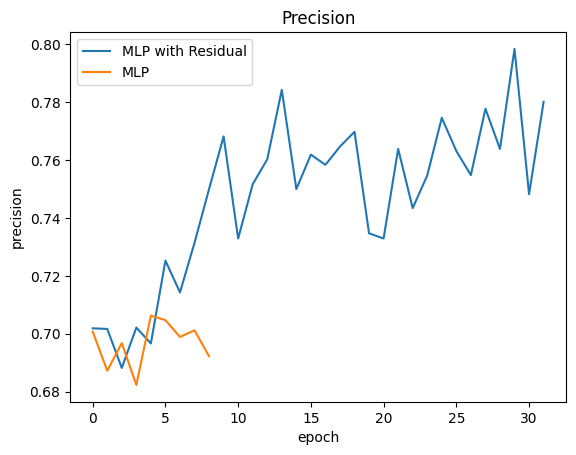

In [109]:
plt.plot(r_precision)
plt.plot(precision)
plt.xlabel("epoch")
plt.ylabel("precision")
plt.title("Precision")
plt.legend(['MLP with Residual','MLP'])
plt.show()

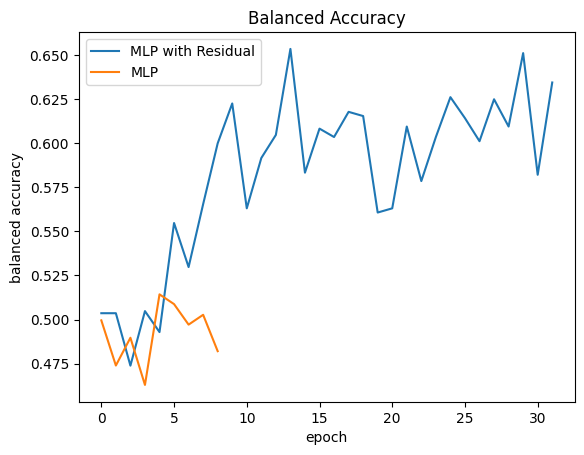

In [108]:
plt.plot(r_balanced_accuracy)
plt.plot(balanced_accuracy)
plt.xlabel("epoch")
plt.ylabel("balanced accuracy")
plt.title("Balanced Accuracy")
plt.legend(['MLP with Residual','MLP'])
plt.show()

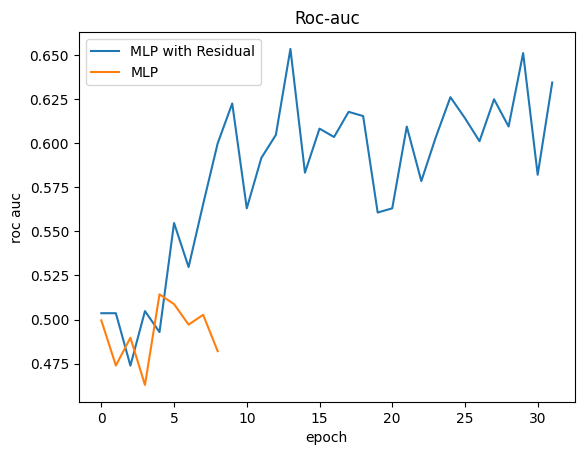

In [107]:
plt.plot(r_roc_auc)
plt.plot(roc_auc)
plt.xlabel("epoch")
plt.ylabel("roc auc")
plt.title("Roc-auc")
plt.legend(['MLP with Residual','MLP'])
plt.show()

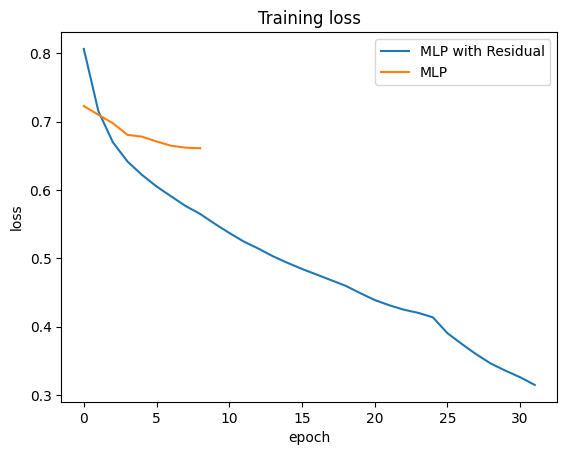

In [106]:
plt.plot(r_mlp_train_loss)
plt.plot(mlp_train_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training loss")
plt.legend(['MLP with Residual','MLP'])
plt.show()